## Cluster visualization
Display random representatives of the cluster - after ACAE filter

In [1]:
import pickle
import os
import sys
import numpy as np
from glob import glob
from sklearn.metrics.cluster import normalized_mutual_info_score
import seaborn as sn
import matplotlib.pyplot as plt
import json
import cv2
import shutil
import re
import torchvision.datasets as datasets



In [2]:
def arrange_clustering(images_lists):
    pseudolabels = []
    image_indexes = []
    for cluster, images in enumerate(images_lists):
        image_indexes.extend(images)
        pseudolabels.extend([cluster] * len(images))
    indexes = np.argsort(image_indexes)
    return np.asarray(pseudolabels)[indexes]

#### Links to files

In [3]:
clusters = "/home/aogorodnikov/deepclust_afterACAE/clusters"
imgs = "/sudoku/anomaly_links/Pt04"

In [4]:
with open(clusters, "rb") as f:
    b = pickle.load(f, encoding='latin1')

In [5]:
# clusters which each img belongs to at every epoch
img_clust = [arrange_clustering(x) for x in b]

In [6]:
dataset = datasets.ImageFolder(imgs)

In [7]:
im_names = [x[0] for x in dataset.imgs]

In [11]:
im_names[0]

'/sudoku/anomaly_links/Pt04/r01/Pt04_r01c01_f01_0021.tif'

In [8]:
epoch = 98

In [9]:
# Class of image clusters to export as JSON
# clusters - list of clustes
# images - array of images that were identified for this cluster

class Cluster(object):
  def __init__(self, clusters, images):
    self.clusters = []
    self.images = []
    
  def clust_append(self, cur_clust, im_id):
    self.clusters.append(cur_clust)
    self.images.append(im_id)
    

In [10]:
# create an object with attributes "clusters" and "images"
myObj = Cluster("Cluster", "Image")

# loop over clusters (j)
for j in range(0,len(b[epoch])):
    rel_img = [im_names[x] for x in np.where(img_clust[epoch] == j)[0]]
    myObj.clust_append(j, rel_img)


#### Export clusters and images to json file

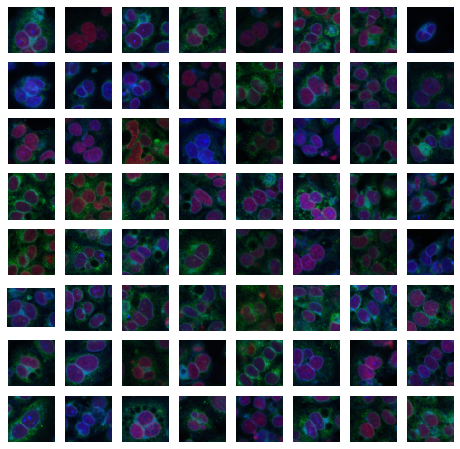

In [34]:
fig=plt.figure(figsize=(8, 8))
columns = 8
rows = 8
clust_to_plot = 75

for k in range(1, columns * rows + 1):
    select_im = myObj.images[clust_to_plot]
    rand_select = [select_im[x] for x in np.random.choice(range(1, len(select_im)), 1)]
    img_import = cv2.imread(rand_select[0], -1)
    fig.add_subplot(rows, columns, k)
    #plt.text(0, 0, s=rand_select)
    plt.imshow(img_import, cmap='gray');
    plt.axis('off')
plt.show()


/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


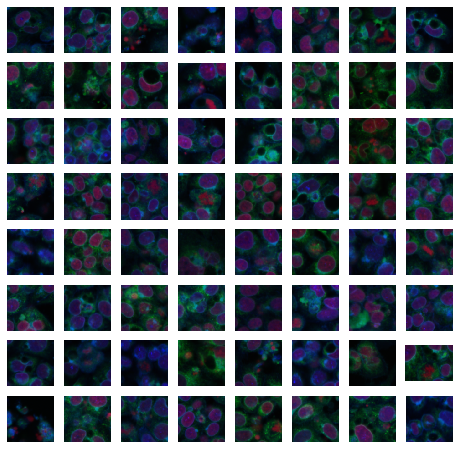

In [35]:
fig=plt.figure(figsize=(8, 8))
columns = 8
rows = 8
for clust_to_plot in range(0, len(myObj.clusters)):
    
    for k in range(1, columns * rows + 1):
        select_im = myObj.images[clust_to_plot]
        rand_select = [select_im[x] for x in np.random.choice(range(1, len(select_im)), 1)]
        img_import = cv2.imread(rand_select[0], -1)
        fig.add_subplot(rows, columns, k)
        pic = plt.imshow(img_import, cmap='gray');
        plt.axis('off')
    plt.savefig(fname=os.path.join("/home/aogorodnikov/deepclust_afterACAE/cluster_examples", "_".join(['clust{0:02d}'.format(clust_to_plot),
                                                                            "out.pdf"])))

### Inspecting k-means clusters  
After manually picking interesting clusters, samples were grouped into a separate folder.  
Extract the most relevant clusters to turn them into class

In [24]:
files = [os.path.basename(x) for x in glob("/home/aogorodnikov/model_alex_kmeans300/class/*.pdf")]

In [25]:
clust = [re.search('\d\d', x)[0] for x in files]

In [34]:
lol = [3, 7, 15, 17, 18, 25, 27, 28, 29, 31, 33, 46, 51, 52, 64, 80, 94]
clust = [str(x) for x in lol]


In [41]:

clust

['3',
 '7',
 '15',
 '17',
 '18',
 '25',
 '27',
 '28',
 '29',
 '31',
 '33',
 '46',
 '51',
 '52',
 '64',
 '80',
 '94']

In [42]:
# select images based on supervised clusters
selected = [myObj.images[int(x)] for x in clust]

In [43]:
# copy images in the clusters
for i in range(0,len(selected)):
    outdir = os.path.join("/home/aogorodnikov/train_classifier", "_".join([clust[i], str(len(selected[i]))]))
    # create output dir
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    [shutil.copy(os.path.join("/home/aogorodnikov/data_rgb/train", x), outdir) for x in selected[i]]

In [10]:
with open(os.path.join("/data2/02_sudoku/model_alex/out", "_".join(["imCluster_epoch", str(epoch)])), "w") as file:
    json.dump(myObj.__dict__, file)